<a href="https://colab.research.google.com/github/Reyad02/PoultryScan/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: connect with dirve

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Miscellaneous
import os
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

#For data manipulation
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image, ImageEnhance

#For neural network
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

In [ ]:
#Load Training Data
train_data_dir = '/content/drive/MyDrive/DIP_Aug_dataset/train'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

#Concatenate data paths
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')

train_df = pd.concat([Fseries, Lseries], axis = 1)

In [ ]:
#Load Testing Data
train_data_dir = '/content/drive/MyDrive/DIP_Aug_dataset/test'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

#Concatenate data paths
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name ='labels')

ts_df = pd.concat([Fseries, Lseries], axis = 1)

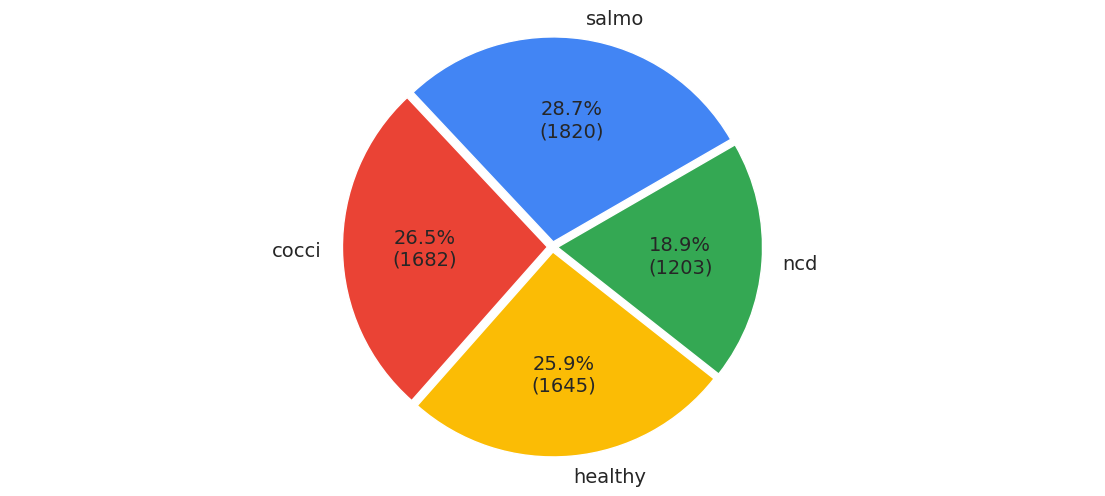

In [ ]:
#Graph Dataset Split
plt.figure(figsize = (14, 6))
plt.rcParams.update({'font.size': 14})
data_balance = train_df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct * total / 100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.pie(data_balance,
        labels = data_balance.index,
        autopct = custom_autopct,
        colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853'],
        explode = (0.025, 0.025, 0.025, 0.025),
        startangle = 30);
plt.axis('equal')
plt.show()

In [ ]:
#Split dataset
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [ ]:
# Augment and Preprocess Scans
batch_size = 32
img_size = (240, 240)

tr_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = test_gen.flow_from_dataframe(ts_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                        class_mode='categorical',
                                        color_mode='rgb', shuffle=False, batch_size=batch_size)
# batch_size = 32
# img_size = (240, 240)

# tr_gen = ImageDataGenerator()
# ts_gen = ImageDataGenerator()

# train_gen = tr_gen.flow_from_dataframe(train_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
#                                     color_mode = 'rgb', shuffle = True, batch_size = batch_size)

# valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
#                                     color_mode = 'rgb', shuffle = True, batch_size = batch_size)

# test_gen = ts_gen.flow_from_dataframe(test_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
#                                     color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 6350 validated image filenames belonging to 4 classes.
Found 1590 validated image filenames belonging to 4 classes.


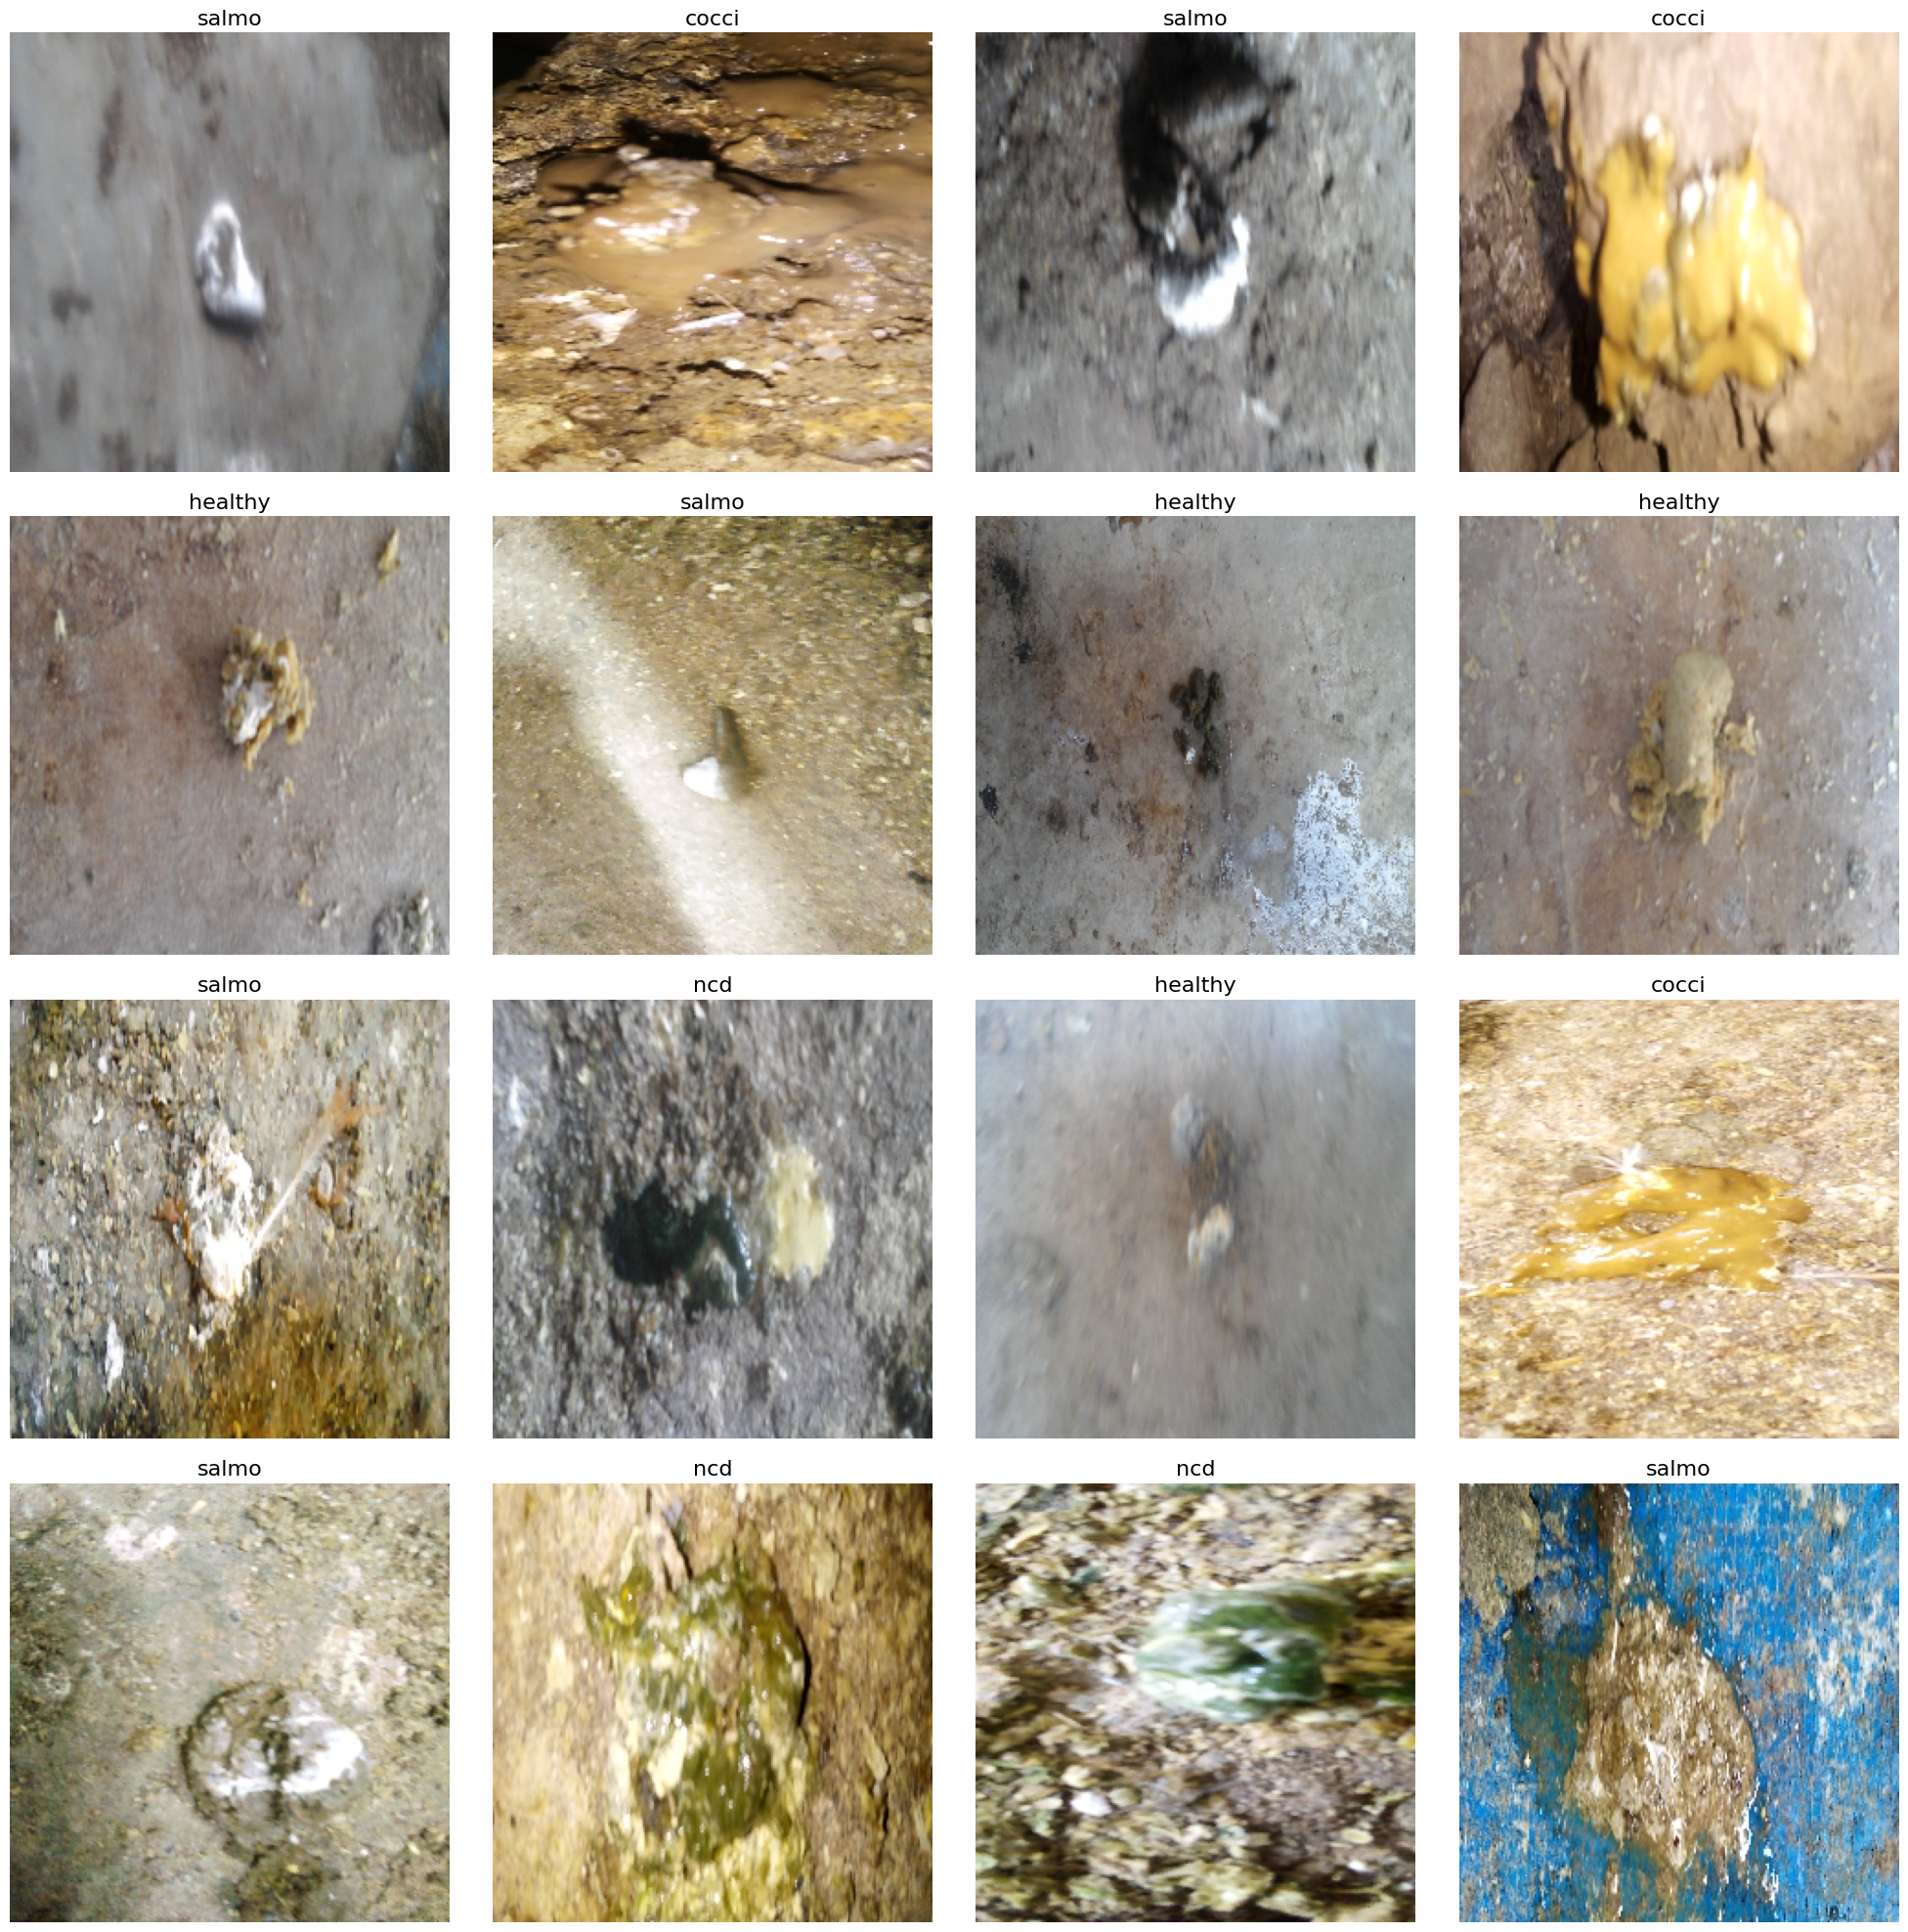

In [ ]:
#Plot Processed Scans
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize = (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color = 'black', fontsize = 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

([<matplotlib.patches.Wedge at 0x7e86397b17b0>,
 [Text(-1.1187437299570697, 0.11847981550349934, 'Training'),
  Text(1.118743735503509, -0.11847976313132515, 'Testing')],
 [Text(-0.6215242944205942, 0.0658221197241663, '80.0%'),
  Text(0.6215242975019494, -0.06582209062851396, '20.0%')])

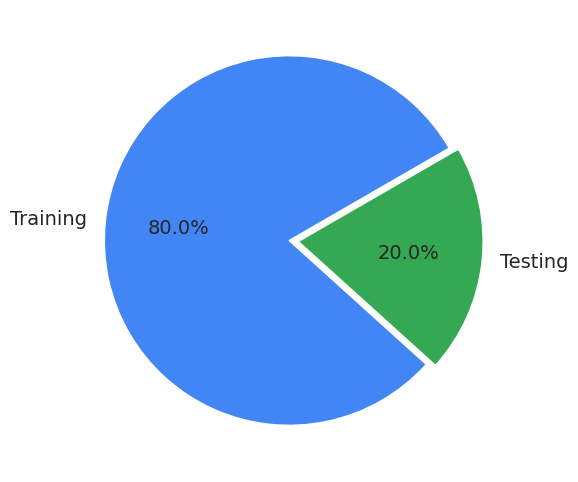

In [ ]:
# Graph Dataset Directories
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size': 14})

plt.pie([len(train_df), len(ts_df)],
        labels=['Training', 'Testing'],
        colors=['#4285f4', '#34a853'],
        autopct='%.1f%%',
        explode=(0.025, 0.025),
        startangle=30)


In [ ]:
# Create model architecture
img_size = 240
class_count = len(train_gen.class_indices)

base_model = VGG19(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()

model.add(Input(shape=(img_size, img_size, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation='softmax'))
# img_size = 240
# class_count = len()

# base_model = VGG19(input_shape = (img_size, img_size, 3), include_top = False, weights = 'imagenet')
# for layer in base_model.layers:list(train_gen.class_indices.keys())
#     layer.trainable = False
# base_model.layers[-2].trainable = True
# base_model.layers[-3].trainable = True
# base_model.layers[-4].trainable = True

# model = Sequential()

# model.add(Input(shape = (img_size, img_size, 3)))
# model.add(base_model)
# model.add(Flatten())
# model.add(Dropout(0.3))
# model.add(Dense(128, activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(Dense(class_count, activation = 'softmax'))

80134624/80134624 [==============================] - 0s 0us/step


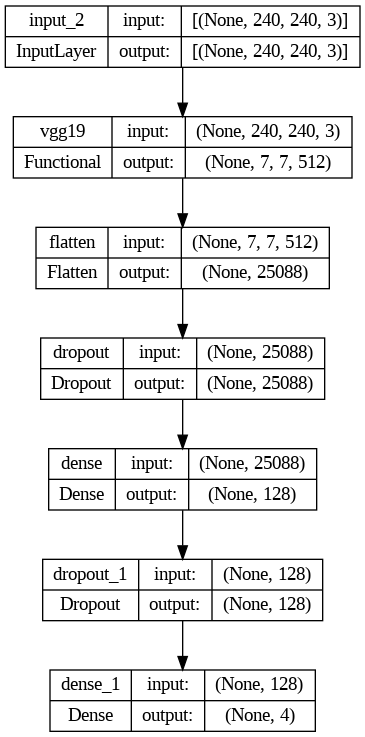

In [ ]:
keras.utils.plot_model(model, show_shapes = True)

In [ ]:
#LETS GO! NO ERRORS! Time to compile
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit(train_gen,
                    epochs=epochs,
                    verbose=1,
                    validation_data=test_gen,
                    shuffle=False)

Epoch 1/10
199/199 [==============================] - 4732s 24s/step - loss: 0.6664 - accuracy: 0.7776 - val_loss: 0.2808 - val_accuracy: 0.9151
Epoch 2/10
199/199 [==============================] - 341s 2s/step - loss: 0.2110 - accuracy: 0.9306 - val_loss: 0.2172 - val_accuracy: 0.9428
Epoch 3/10
199/199 [==============================] - 341s 2s/step - loss: 0.1291 - accuracy: 0.9576 - val_loss: 0.2240 - val_accuracy: 0.9352
Epoch 4/10
199/199 [==============================] - 336s 2s/step - loss: 0.0589 - accuracy: 0.9803 - val_loss: 0.2393 - val_accuracy: 0.9472
Epoch 5/10
199/199 [==============================] - 340s 2s/step - loss: 0.0732 - accuracy: 0.9770 - val_loss: 0.2539 - val_accuracy: 0.9409
Epoch 6/10
199/199 [==============================] - 337s 2s/step - loss: 0.0593 - accuracy: 0.9800 - val_loss: 0.1899 - val_accuracy: 0.9553
Epoch 7/10
199/199 [==============================] - 345s 2s/step - loss: 0.0516 - accuracy: 0.9857 - val_loss: 0.3733 - val_accuracy: 0.94

In [ ]:
import torch

In [ ]:

# Save the entire model
model.save('/content/drive/MyDrive/Models_for_Enesemble_Learning/vgg19_model.h5')


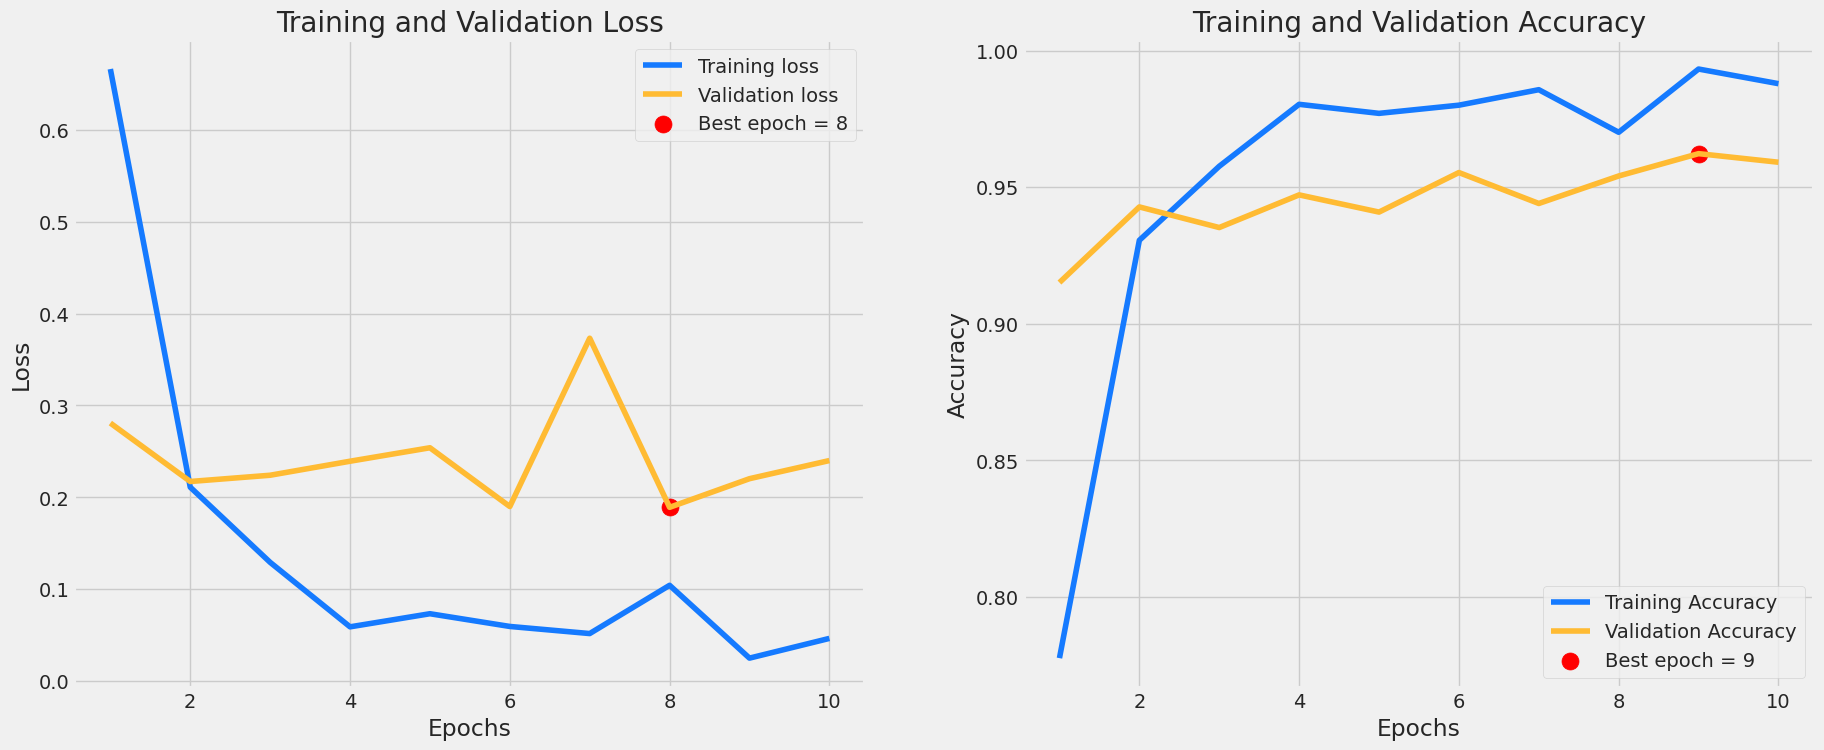

In [ ]:
#Graph results
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
#Results for training, validating, testing

# Results for training and testing
train_score = model.evaluate(train_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

50/50 [==============================] - 67s 1s/step - loss: 0.2400 - accuracy: 0.9591
Train Loss:  0.020067255944013596
Train Accuracy:  0.9946456551551819
--------------------
Test Loss:  0.2399965077638626
Test Accuracy:  0.9591194987297058


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

50/50 [==============================] - 62s 1s/step


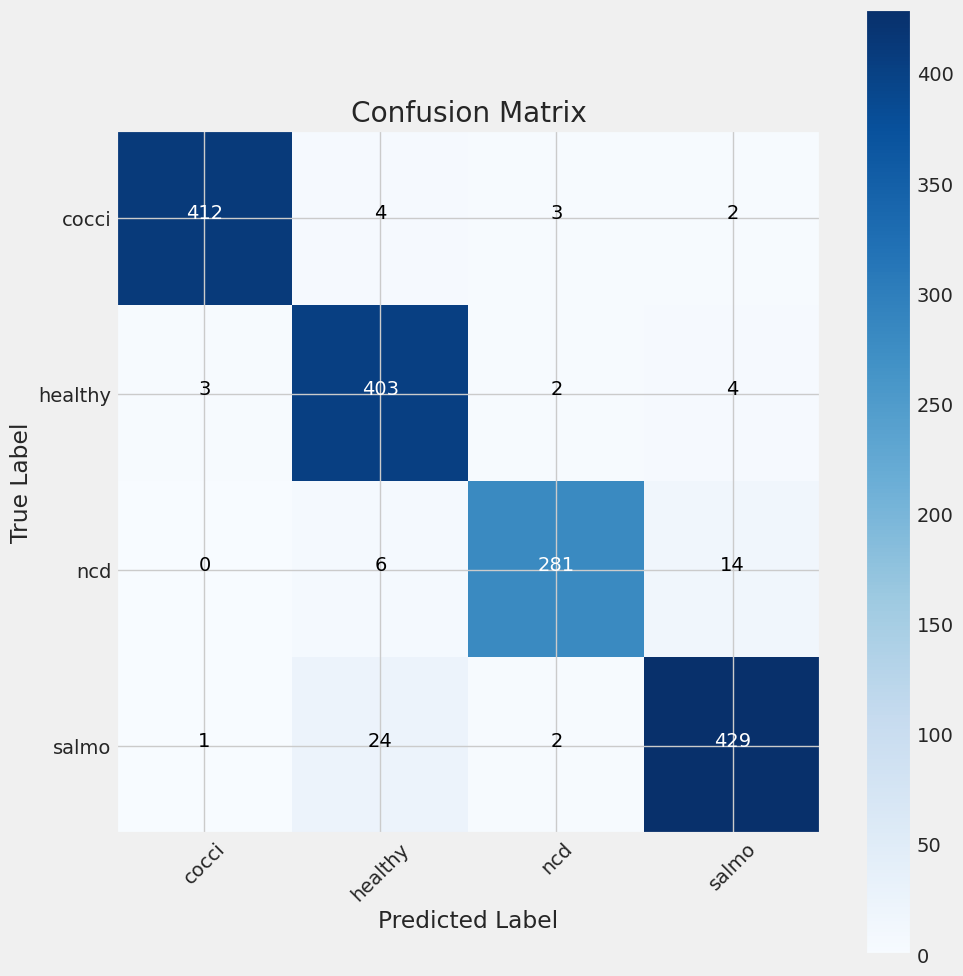

In [ ]:
#Confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize = (10, 10))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#F1-score
print(classification_report(test_gen.classes, y_pred, target_names = classes))

              precision    recall  f1-score   support

       cocci       0.99      0.98      0.98       421
     healthy       0.92      0.98      0.95       412
         ncd       0.98      0.93      0.95       301
       salmo       0.96      0.94      0.95       456

    accuracy                           0.96      1590
   macro avg       0.96      0.96      0.96      1590
weighted avg       0.96      0.96      0.96      1590



In [ ]:
from sklearn.metrics import roc_curve, auc
y_pred = model.predict(test_gen)

50/50 [==============================] - 59s 1s/step


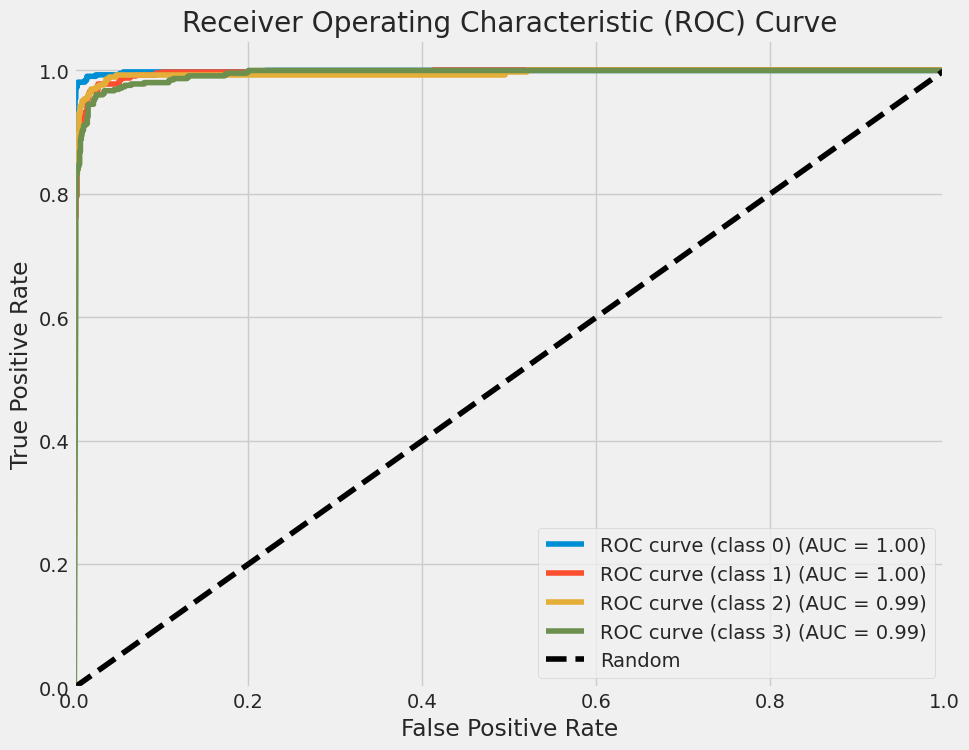

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Check if test_gen.classes is a list of one-hot encoded vectors
if isinstance(test_gen.classes[0], list) or isinstance(test_gen.classes[0], np.ndarray):
    true_labels = np.argmax(test_gen.classes, axis=1)
else:
    true_labels = test_gen.classes

for i in range(class_count):  # class_count is the number of classes
    fpr[i], tpr[i], _ = roc_curve(np.array(true_labels) == i, y_pred[:, i])  # Treat i-th class as positive, rest as negative
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(class_count):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (AUC = {:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
